In [16]:
import pandas as pd
import requests
import numpy as np
import time
from tqdm import tqdm
import pickle

mapbox_api_key = YOUR_MAPBOX_API_KEY
target_streets = ['dean street', 'bergen street'] # lower case
sample_size = 10000 # in my testing, 100k samples was sufficient. check mapbox pricing before sending >100k requests :) 
random_state = 123 # if running your requests in batches, you must change this between runs or else you will sample the same rows

In [2]:
trips = pd.read_pickle('2023-citibike-tripdata/unique_trips.pkl')
trips.head()

,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng
0,5712.12,5270.07,40.727690,-73.990993,40.715815,-73.994224
1,5743.02,5743.02,40.729840,-73.948390,40.729840,-73.948390
2,5379.10,5379.10,40.717361,-73.958464,40.717452,-73.958509
3,5473.06,5291.05,40.667430,-73.934199,40.715143,-73.944507
4,6257.03,6140.05,40.744876,-73.995299,40.741740,-73.994156


## Sample evenly distributed stations

We can't just randomly sample trips, because our sample will reflect the most common trips types (e.g. Lower manhattan to midtown)
Since we want to build a model to predict routes, we need a geographically even sample.
We'll do this by splitting NYC into a grid of 25x25, then sample from that grid to ensure an even distribution across the city.

In [45]:
grid_dim = 10

# calculate min and max coordinates for start and end points
min_start_lat, max_start_lat = trips['start_lat'].min(), trips['start_lat'].max()
min_start_lng, max_start_lng = trips['start_lng'].min(), trips['start_lng'].max()
min_end_lat, max_end_lat = trips['end_lat'].min(), trips['end_lat'].max()
min_end_lng, max_end_lng = trips['end_lng'].min(), trips['end_lng'].max()

# define grid cell size
start_lat_step = (max_start_lat - min_start_lat) / grid_dim
start_lng_step = (max_start_lng - min_start_lng) / grid_dim
end_lat_step = (max_end_lat - min_end_lat) / grid_dim
end_lng_step = (max_end_lng - min_end_lng) / grid_dim

# assign grid cell indices for start and end locations
trips['start_lat_idx'] = ((trips['start_lat'] - min_start_lat) / start_lat_step).astype(int)
trips['start_lng_idx'] = ((trips['start_lng'] - min_start_lng) / start_lng_step).astype(int)
trips['end_lat_idx'] = ((trips['end_lat'] - min_end_lat) / end_lat_step).astype(int)
trips['end_lng_idx'] = ((trips['end_lng'] - min_end_lng) / end_lng_step).astype(int)

# ensure indices are within grid bounds
trips['start_lat_idx'] = trips['start_lat_idx'].clip(0, grid_dim - 1)
trips['start_lng_idx'] = trips['start_lng_idx'].clip(0, grid_dim - 1)
trips['end_lat_idx'] = trips['end_lat_idx'].clip(0, grid_dim - 1)
trips['end_lng_idx'] = trips['end_lng_idx'].clip(0, grid_dim - 1)

# combine indices to form a unique grid cell id
trips['grid_cell'] = (
    trips['start_lat_idx'].astype(str) + '_' +
    trips['start_lng_idx'].astype(str) + '_' +
    trips['end_lat_idx'].astype(str) + '_' +
    trips['end_lng_idx'].astype(str)
)

In [58]:
# determine the number of samples per grid cell
desired_sample_size = sample_size  # adjust based on total desired samples
unique_grid_cells = trips['grid_cell'].nunique()
samples_per_cell = max(1, desired_sample_size // unique_grid_cells)

# sample from each grid cell
sampled_trips = trips.groupby('grid_cell').apply(
    lambda x: x.sample(n=min(len(x), samples_per_cell), random_state=random_state)
).reset_index(drop=True)

# if additional samples are needed due to empty cells, sample randomly
current_sample_size = len(sampled_trips)
if current_sample_size < desired_sample_size:
    additional_samples = desired_sample_size - current_sample_size
    remaining_trips = trips[~trips.index.isin(sampled_trips.index)]
    additional_sampled = remaining_trips.sample(n=additional_samples, random_state=random_state)
    sampled_trips = pd.concat([sampled_trips, additional_sampled], ignore_index=True)


## Get directions

In [15]:
# mapbox access token
access_token = mapbox_api_key

def get_directions(start_lat, start_lng, end_lat, end_lng):
    url = f'https://api.mapbox.com/directions/v5/mapbox/cycling/{start_lng},{start_lat};{end_lng},{end_lat}'
    params = {
        'alternatives': 'false',
        'geometries': 'geojson',
        'steps': 'true',
        'access_token': access_token
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        return None
    

def check_for_target_streets(directions, target_streets):
    if not directions:
        return False
    try:
        steps = directions['routes'][0]['legs'][0]['steps']
        streets_in_route = [step['name'].lower() for step in steps if step['name']]
        return any(
            target in street_name
            for street_name in streets_in_route
            for target in target_streets
        )
    except (IndexError, KeyError, TypeError):
        return False

In [59]:
directions_list = []

for index, row in tqdm(sampled_trips.iterrows()):
    directions = get_directions(
        row['start_lat'], row['start_lng'],
        row['end_lat'], row['end_lng']
    )
    directions_list.append(directions)
    # delay to respect rate limits
    time.sleep(0.3)  

28000it [3:35:32,  2.17it/s]


In [60]:
with open('2023-citibike-tripdata/directions_list.pkl', 'wb') as f:
    pickle.dump(directions_list, f)

In [61]:
target_streets = ['dean street', 'bergen street']

# apply the function to each directions response
sampled_trips['contains_target_street'] = [
    check_for_target_streets(directions, target_streets)
    for directions in directions_list
]

In [62]:
sampled_trips[sampled_trips['contains_target_street']==True]

,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,start_lat_idx,start_lng_idx,end_lat_idx,end_lng_idx,grid_cell,contains_target_street
48,2782.02,4322.06,40.635679,-74.020005,40.682564,-73.979898,0,0,1,2,0_0_1_2,True
49,2923.01,4281.08,40.639927,-74.019815,40.680945,-73.975673,0,0,1,2,0_0_1_2,True
54,3243.02,4199.07,40.649143,-74.012384,40.680092,-73.971180,0,0,1,3,0_0_1_3,True
60,2923.01,4214.03,40.639927,-74.019815,40.680983,-73.950048,0,0,1,4,0_0_1_4,True
61,3211.06,4107.13,40.647440,-74.018846,40.677592,-73.955637,0,0,1,4,0_0_1_4,True
...,...,...,...,...,...,...,...,...,...,...,...,...
27917,3759.07,4107.05,40.664810,-73.942690,40.675832,-73.956168,1,4,1,3,1_4_1_3,True
27920,4220.02,4637.07,40.679301,-73.921887,40.695000,-73.989170,1,5,2,2,1_5_2_2,True
27945,4054.02,4446.01,40.675327,-74.010070,40.686744,-73.990632,1,0,2,2,1_0_2_2,True
27949,4853.06,4066.15,40.701083,-73.984684,40.676368,-73.952918,2,2,1,4,2_2_1_4,True


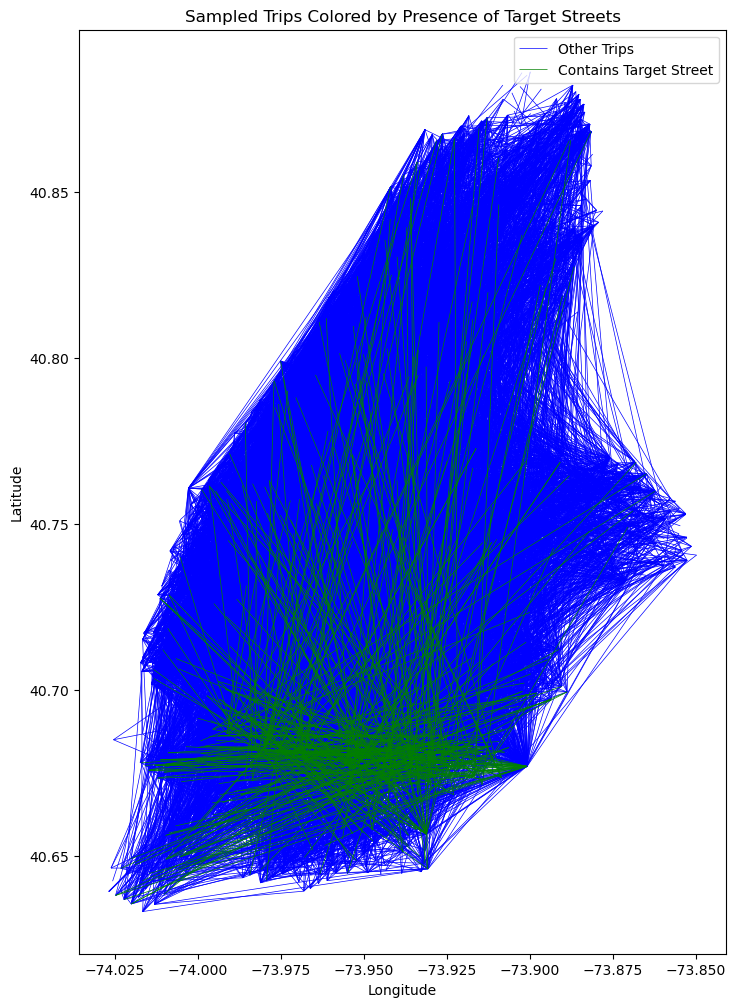

In [28]:
import geopandas as gpd
from shapely.geometry import LineString
import matplotlib.pyplot as plt


# Ensure there are no missing coordinate values
sampled_trips = sampled_trips.dropna(subset=['start_lat', 'start_lng', 'end_lat', 'end_lng'])

# Create the geometry column with lines between start and end points
sampled_trips['geometry'] = sampled_trips.apply(
    lambda row: LineString([
        (row['start_lng'], row['start_lat']),
        (row['end_lng'], row['end_lat'])
    ]),
    axis=1
)

# Create a GeoDataFrame without changing the CRS
gdf = gpd.GeoDataFrame(sampled_trips, geometry='geometry')

# Separate the trips based on 'contains_target_street'
gdf_true = gdf[gdf['contains_target_street'] == True]
gdf_false = gdf[gdf['contains_target_street'] == False]

# Create a plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the trips where contains_target_street is False in blue
gdf_false.plot(ax=ax, linewidth=0.5, color='blue', label='Other Trips')

# Plot the trips where contains_target_street is True in green
gdf_true.plot(ax=ax, linewidth=0.5, color='green', label='Contains Target Street')

# Add a legend
ax.legend()

# Set labels (optional)
ax.set_title('Sampled Trips Colored by Presence of Target Streets')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

In [63]:
sampled_trips.to_pickle('2023-citibike-tripdata/sampled_trips.pkl')

In [43]:
sampled_trips['contains_target_street'].sum()/len(sampled_trips)

0.0394